## automating the regularization parameter tuning

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import wobble
import tensorflow as tf
from tqdm import tqdm

/Users/mbedell/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
starname = '51peg'
o = 0
data = wobble.Data(starname+'_e2ds.hdf5', filepath='data/', orders=[o])
results = wobble.Results(data=data)

In [3]:
validation_epochs = np.random.choice(data.N, data.N//10, replace=False)
training_epochs = np.delete(np.arange(data.N), validation_epochs)
    
training_data = wobble.Data('51peg_e2ds.hdf5', filepath='data/', orders=[o], mask_epochs=validation_epochs)
training_results = wobble.Results(training_data)

validation_data = wobble.Data('51peg_e2ds.hdf5', filepath='data/', orders=[o], mask_epochs=training_epochs)
validation_results = wobble.Results(validation_data)

In [4]:
r = 0
training_model = wobble.Model(training_data, training_results, r)
training_model.add_star('star')
training_model.add_telluric('tellurics', rvs_fixed=True, variable_bases=3)
training_model.setup()

validation_model = wobble.Model(validation_data, validation_results, r)
validation_model.add_star('star')
validation_model.add_telluric('tellurics', rvs_fixed=True, variable_bases=3)
validation_model.setup()

In [5]:
regularization_dict = {training_model.components[0].L1_template_tensor: 0.,
                      training_model.components[0].L2_template_tensor: 0.,
                      training_model.components[1].L1_template_tensor: 0.,
                      training_model.components[1].L2_template_tensor: 1.e5,
                      training_model.components[1].L1_basis_vectors_tensor: 0.,
                      training_model.components[1].L2_basis_vectors_tensor: 1.e5,
                      training_model.components[1].L2_basis_weights_tensor: 1.0}

In [6]:
zero_regularization_dict = {**regularization_dict}
for key in zero_regularization_dict:
    zero_regularization_dict[key] = 0.0

In [7]:
def test_regularization_value(par, value, training_model, validation_model, regularization_dict, plot=False):
    '''
    Try setting regularization parameter `par` to value `value`; return goodness metric `nll`.
    '''
    regularization_dict[par] = value
    training_model.optimize(niter=60, feed_dict=regularization_dict)
    validation_dict = {**regularization_dict}
    for c in validation_model.components:
        validation_dict[getattr(c, 'template_xs')] = getattr(training_model.results, c.name+'_template_xs')[training_model.r]
        validation_dict[getattr(c, 'template_ys')] = getattr(training_model.results, c.name+'_template_ys')[training_model.r]
        if c.K > 0:
            validation_dict[getattr(c, 'basis_vectors')] = getattr(training_model.results, c.name+'_basis_vectors')[training_model.r]
    session = wobble.utils.get_session()
    for i in tqdm(range(60)):
        for c in validation_model.components:
            if not c.rvs_fixed:
                session.run(c.opt_rvs, feed_dict=validation_dict) # HACK
            if c.K > 0:
                session.run(c.opt_basis_weights, feed_dict=validation_dict)

    if plot:
        for c in validation_model.components:
            validation_model.results.update(c)
        n = validation_epochs[0]
        fig, ax = plt.subplots(1, 1, figsize=(12,5))
        ax.plot(np.exp(data.xs[r][n]), np.exp(data.ys[r][n]), color='k')
        ax.plot(np.exp(data.xs[r][n]), np.exp(validation_results.star_ys_predicted[r][n]), color='r', alpha=0.5)
        ax.plot(np.exp(data.xs[r][n]), np.exp(validation_results.tellurics_ys_predicted[r][n]), color='b', alpha=0.8)
        #ax.set_xlim([3935,3940])
        ax.set_ylim([0.0,1.3])
        fig.show()
    return session.run(validation_model.nll, feed_dict=zero_regularization_dict)

100%|██████████| 60/60 [00:01<00:00, 39.62it/s]
/Users/mbedell/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
100%|██████████| 60/60 [00:01<00:00, 41.82it/s]


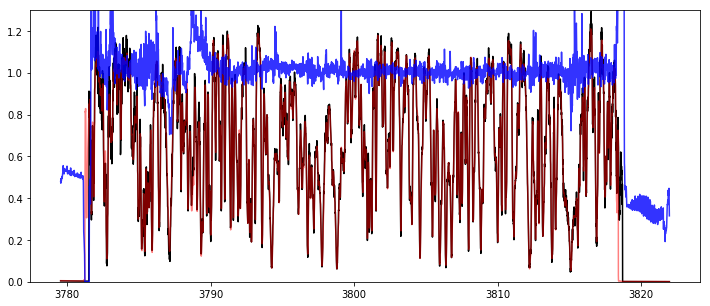

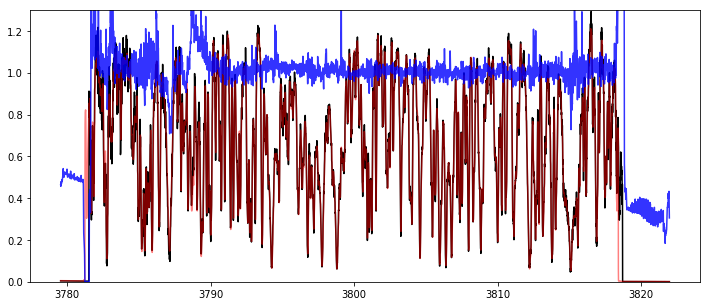

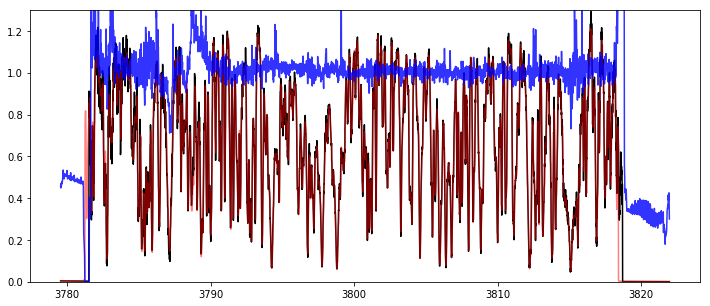

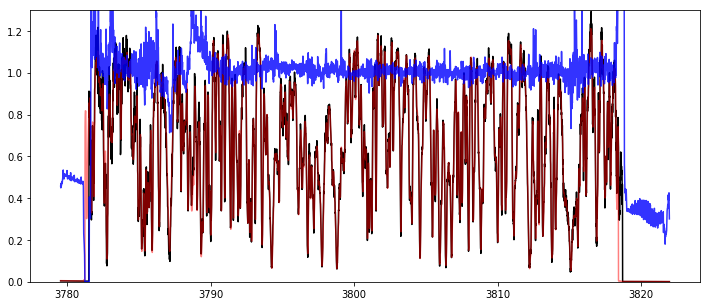

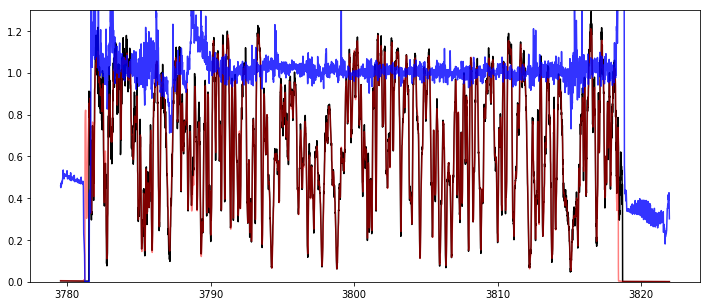

In [8]:
par = training_model.components[1].L2_basis_vectors_tensor
current_value = np.copy(regularization_dict[par])
grid = np.logspace(-2.0, 2.0, num=5) * current_value
nll_grid = np.zeros_like(grid)
for i,val in enumerate(grid):
    nll_grid[i] = test_regularization_value(par, val, training_model, validation_model, regularization_dict, plot=True)

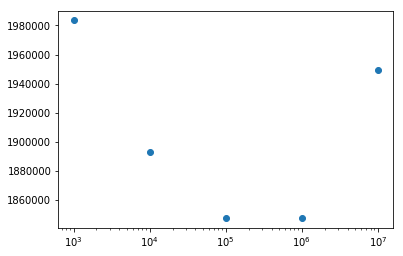

In [9]:
plt.scatter(grid, nll_grid)
plt.xscale('log')

In [10]:
validation_epochs[0]

4

In [11]:
grid

array([1.e+03, 1.e+04, 1.e+05, 1.e+06, 1.e+07])

In [12]:
nll_grid

array([1983430.7370087 , 1892853.20482815, 1847795.06030315,
       1847939.35222882, 1949664.03376942])